In [2]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import time
import numpy as np
import argparse
import cv2

import theano
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

from keras.optimizers import SGD, RMSprop
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
from sklearn import datasets

print 'Keras ', keras.__version__
print 'Theano', theano.__version__
print 'OpenCV', cv2.__version__
print 'Numpy ', np.__version__

Using gpu device 0: Tesla C2050 (CNMeM is disabled, cuDNN not available)
Using Theano backend.


Keras  1.2.1
Theano 0.8.2
OpenCV 2.4.10
Numpy  1.10.4


In [4]:
from keras.datasets import mnist
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print X_train.shape, X_test.shape
print y_train.shape, y_test.shape

(60000, 1, 28, 28) (10000, 1, 28, 28)
(60000, 10) (10000, 10)


## Carregando nosso modelo pre-treinado

In [5]:
print("[INFO] loading model...")
model_name = './keras_lenet_1'
model_A, histo_A = load_model_and_history(model_name)

print("[INFO] evaluating...")
loss, accuracy = model_A.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

[INFO] loading model...
[INFO] evaluating...
 9984/10000 [============================>.] - ETA: 0s[INFO] accuracy: 99.34%


## Modelo totalmente convolucional equivalente

O modelo seguinte é todo ele convolucional.

In [6]:
model_name = './keras_lenet_fullconv'

class LeNet:
    @staticmethod
    def build():
        model = Sequential()
        
        model.add(Convolution2D(20, 5, 5, border_mode="same", 
                                batch_input_shape=(128, 1, None, None)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Convolution2D(50, 5, 5, border_mode="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Convolution2D(500, 7, 7, border_mode="valid"))        
        model.add(Activation("relu"))

        model.add(Convolution2D(10, 1, 1, border_mode="valid"))        

        return model

model_B = LeNet.build()
model_B.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (128, 20, None, None) 520         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (128, 20, None, None) 0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (128, 20, None, None) 0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (128, 50, None, None) 25050       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

## Ajustando os pesos do modelo todo convolucional

In [7]:
W_all_A = model_A.get_weights()

W_all_B = [
    W_all_A[0],
    W_all_A[1],
    W_all_A[2],
    W_all_A[3],
    W_all_A[4].T.reshape(500, 50, 7, 7)[:, :, ::-1, ::-1],
    W_all_A[5],
    W_all_A[6].T.reshape(10, 500, 1, 1)[:, :, ::-1, ::-1],
    W_all_A[7],
]
model_B.set_weights(W_all_B)

model_B.compile(optimizer='sgd', loss="categorical_crossentropy")


## Verificando a performance

In [8]:
pp = model_B.predict(X_test[:1])
print pp.shape

(1, 10, 1, 1)


112 56
144 148
108 4
164 40
76 12


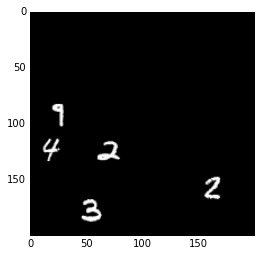

In [15]:
N = 5
char_index = np.random.choice(X_test.shape[0], N, replace=False)
char_img = [img.reshape(28,28) for img in (255*X_test).astype(np.uint8)[char_index]]

image = np.zeros((200, 200), np.uint8)
for k, (i, j) in enumerate(np.random.choice((200-28)/4, (N, 2), replace=False)):
    i, j = i*4, j*4
    print i, j
    image[i:i+28, j:j+28] = np.maximum(image[i:i+28, j:j+28], char_img[k])
    
plot.imshow(image, cmap=plot.cm.gray)

In [16]:
def softmax(Z):
    EZ = np.exp(Z)
    S = EZ / EZ.sum(axis=-1,keepdims=True)
    return S

pp = model_B.predict(image.astype(np.float32).reshape(1, 1, 200, 200)/255.0)[0]
print pp.shape
ppt = pp.transpose(1, 2, 0)
print ppt.shape
sm = softmax(ppt)
sm = np.where(sm > 0.99, sm, 0)
sm = np.argmax(sm, axis=-1)
for i in range(44):
    str = []
    for j in range(44):
        if sm[i,j] == 0:
            str.append('.')
        else:
            str.append('{}'.format(sm[i,j]))
    print ''.join(str)


(10, 44, 44)
(44, 44, 10)
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
............................................
..99........................................
............................................
.............................